# Flux with MNIST


## Libraries

In [1]:
#using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();


In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### tanh

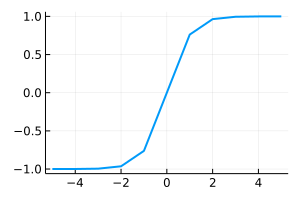

In [7]:
plot(-5:5, tanh.(-5:5), size=(300,200), linewidth=2, legend=false)


### Model

Stochastic Gradient Descent (SGD) means batchsize=1.

The error on every and each data line is computed, then weights are recalculated towards the negative of the gradient.

For this reason, calculation is done at CPU (sequencial computation over one data point at a time).

In [8]:
# model configuration
nInputs  = d
nOutputs = 10
model = Chain( Flux.Dense(nInputs, nOutputs, tanh),   # tanh is chosen as nonlinearity (Prof Mostafa lecture)
               softmax )                              # softmax scales the output to sum to one

lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
data               = Flux.DataLoader((X, y), batchsize=1)             # default batchsize=1
callBack           = Flux.throttle(() -> println("training"), 10);    # print every 10s


### Train method 1

In [9]:
numberOfEpochs = 10;

In [10]:
# preferred for multiple epochs
epochs = 1:numberOfEpochs
@time for epoch in epochs Flux.train!(lossFunction, modelParameters, data, Flux.Descent(); cb=callBack) end

training
training
training
training
 56.287582 seconds (135.62 M allocations: 23.274 GiB, 3.03% gc time, 43.21% compilation time)


### Predict

In [11]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

ŷ = predictOutcome(X);


In [12]:
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 4061     2    35    18    20    76    25    19    46    40
    0  4581    24    12    15    21    14    25    75    17
    5    27  3698   100    21    22    17    44    54    24
    9    13    56  3857     5   154     4    13   107    84
    6     3    84     7  3786    65    24    56    39   144
   11    25    14   103     3  3187    46     7   114    30
   26    10    60    37    38    99  3985     5    40     3
    4    11    79    44     8    24     4  4115    23   160
   21    42   103    70    35    99    23    11  3551    44
    3     5    18    44   158    48     1    91    47  3618

accuracy: 0.915
f1-score: 0.914


### Demo ML

Press CTRL-ENTER on the cell to change.

,,,,,,,

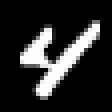
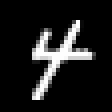
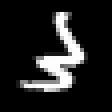
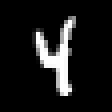
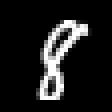
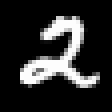
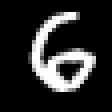
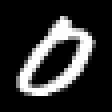

1×8 adjoint(::Vector{Int64}) with eltype Int64:
 4  4  2  4  8  2  6  0

In [13]:
v = rand(1:N, 8)
display([MNIST.convert2image(trainX[:,:,i]) for i in v])
ŷ[v]'